In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree, KDTree
from scipy.interpolate import griddata
from tqdm import tqdm
from scipy.interpolate import griddata, RegularGridInterpolator

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#  Размеры ТРС
R_inner = 0.341 # м
R_outer = 1.33 # м
L = 1.65 # м
# Число электронов
N = 500000
# Дрейфовые характеристики
T_stab = 293.5 # K
delta_T = 0.18 # K
# K = 2.02202e-3 # 1/C
v0 = 59130.02055-12.71297*T_stab # м/с
# lambda_Ar = 68e-9
# D = 1/3*lambda_Ar*np.sqrt(8*1.38e-23*298*6.02e23/np.pi/39.95e-3) # м^2/с
D_trans = 0.14057 # м^2/с
D_long = 0.33713 # м^2/с
t_stab = L/v0 # с
print(v0)
print(t_stab)

55398.763855
2.9784058076073472e-05


Index(['Temperature', 'Points:0', 'Points:1', 'Points:2'], dtype='object')
2168832


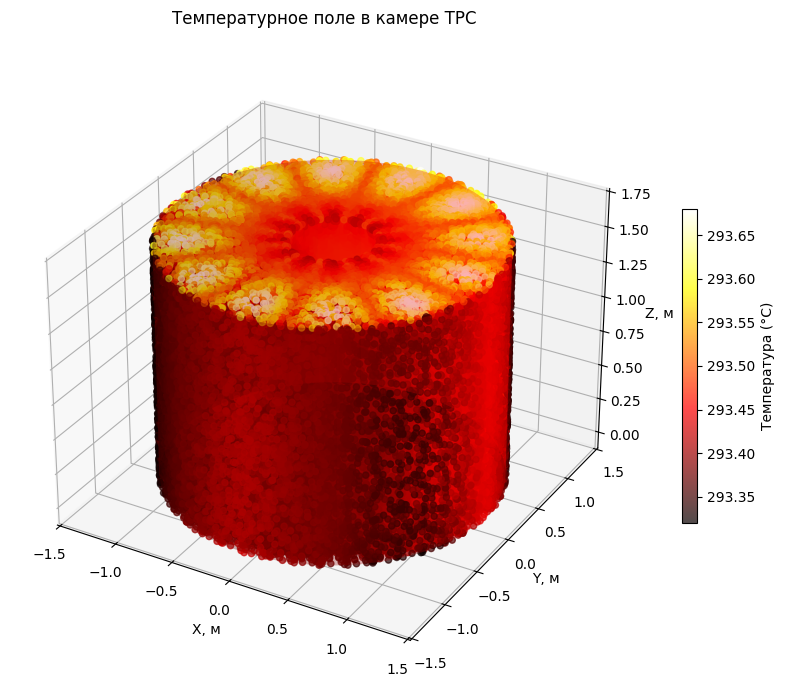

In [ ]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/tpc_temp_field.csv')

print(df.columns)
T = df['Temperature']
Z = -df['Points:0']+L
X = df['Points:1']
Y = df['Points:2']
print(len(T))
# grid_resolution = 50 # Разрешение сетки Т

# r = np.linspace(R_inner, R_outer, grid_resolution//2)
# phi = np.linspace(0, 2*np.pi, grid_resolution//2, endpoint=False)
# z = np.linspace(0, L, grid_resolution//2)
# R, Phi, Z = np.meshgrid(r, phi, z, indexing='ij')

# # Тестовое поле температуры
# T = T_stab+delta_T*(np.sin(2*np.pi*Z/L)*np.sin(3*np.pi*(R-R_inner)/(R_outer-R_inner)))

# X = R*np.cos(Phi)
# Y = R*np.sin(Phi)

fig = plt.figure(figsize=(9, 7))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(X[::10], Y[::10], Z[::10], c=T[::10], cmap='hot', s=20, alpha=0.7)
ax.set_xlabel('X, м')
ax.set_ylabel('Y, м')
ax.set_zlabel('Z, м')
ax.set_title('Температурное поле в камере TPC', pad=20)
cbar = fig.colorbar(sc, shrink=0.5)
cbar.set_label('Температура (°C)')
theta = np.linspace(0, 2*np.pi, 50)
z_cyl = np.array([0, L])
X_outer = R_outer * np.outer(np.cos(theta), np.ones_like(z_cyl))
Y_outer = R_outer * np.outer(np.sin(theta), np.ones_like(z_cyl))
Z_outer = np.outer(np.ones_like(theta), z_cyl)
ax.plot_surface(X_outer, Y_outer, Z_outer, color='red', alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
A_DP = np.array([
        [0, 0, 0, 0, 0, 0, 0],
        [1/5, 0, 0, 0, 0, 0, 0],
        [3/40, 9/40, 0, 0, 0, 0, 0],
        [44/45, -56/15, 32/9, 0, 0, 0, 0],
        [19372/6561, -25360/2187, 64448/6561, -212/729, 0, 0, 0],
        [9017/3168, -355/33, 46732/5247, 49/176, -5103/18656, 0, 0],
        [35/384, 0, 500/1113, 125/192, -2187/6784, 11/84, 0]
    ])

B_DP = np.array([35/384, 0, 500/1113, 125/192, -2187/6784, 11/84, 0])
B_ERR_DP = np.array([5179/57600, 0, 7571/16695, 393/640, -92097/339200, 187/2100, 1/40])
C_DP = np.array([0, 1/5, 3/10, 4/5, 8/9, 1, 1])

def dormand_prince(func, t0, z0, h, tolerance=1e-6):

    k_coeff = np.zeros(7)
    for i in range(7):
        sum = np.dot(A_DP[i, :i], k_coeff[:i])
        z_arg = z0 + h*sum
        t_arg = t0 + h*C_DP[i]
        k_coeff[i] = func(t_arg, z_arg)

    z1 = z0 + h*np.dot(B_DP, k_coeff)
    error = abs(h*np.dot(B_DP-B_ERR_DP, k_coeff)) # Оцениваем ошибку z1

    h_corr = 0.8*h*(tolerance/error)**(1/6)

    return z1, error, h_corr

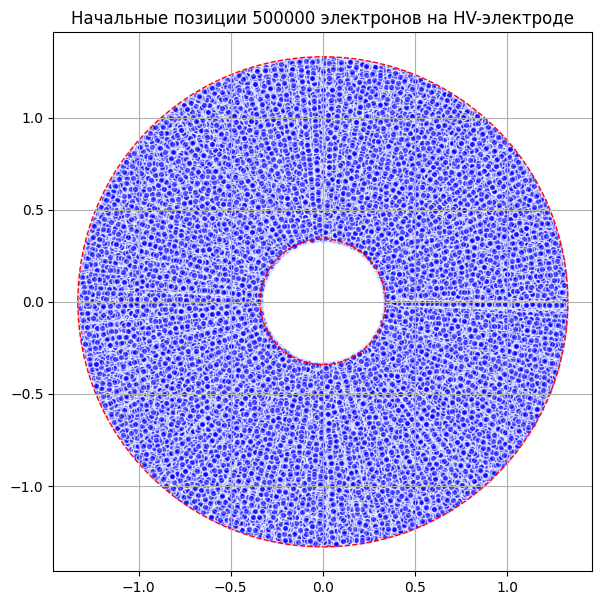

In [ ]:
def generate_electrons(R_inner, R_outer, N, points_per_radius=20):

    N_radii = int(N/points_per_radius) # Число лучей
    angles = np.random.uniform(0, 2*np.pi, N_radii) # Рандомно выбираем угол для каждого луча

    x, y = [], []
    for phi in angles:

        r = np.random.uniform(R_inner, R_outer*0.99, points_per_radius) # Электроны распределены равномерно вдоль луча
        x.extend(r*np.cos(phi))
        y.extend(r*np.sin(phi))

    return np.array(x), np.array(y)

# Начальные позиции электронов
initial_coords = generate_electrons(R_inner, R_outer, N)

plt.figure(figsize=(7, 7))
plt.scatter(initial_coords[0], initial_coords[1], s=20, c='blue', alpha=0.6, edgecolors='w')
plt.gca().add_patch(plt.Circle((0,0), R_outer, fill=False, ec='red', ls='--', lw=1))
plt.gca().add_patch(plt.Circle((0,0), R_inner, fill=False, ec='red', ls='--', lw=1))
plt.title(f"Начальные позиции {N} электронов на HV-электроде")
plt.xlim(-R_outer*1.1, R_outer*1.1)
plt.ylim(-R_outer*1.1, R_outer*1.1)
plt.gca().set_aspect('equal')
plt.grid(True)
plt.show()

In [ ]:
r2 = X**2 + Y**2
inside = (r2 >= R_inner**2) & (r2 <= R_outer**2) & (Z >= 0) & (Z <= L)
X_c, Y_c, Z_c, T_c = X[inside], Y[inside], Z[inside], T[inside]
step = 0.005       # размер воксела, м
Nx = int(np.ceil((2*R_outer) / step)) + 1
Ny = Nx
Nz = int(np.ceil(L / step))        + 1

x0 = -R_outer
y0 = -R_outer
z0 = 0
from scipy.stats import binned_statistic_dd

sample   = np.column_stack((X_c, Y_c, Z_c))
values   = T_c.values   # или np.asarray(T_c)
stat, edges, _ = binned_statistic_dd(
        sample, values,
        statistic='mean',
        bins=[Nx, Ny, Nz],
        range=[(x0, x0 + Nx*step),
               (y0, y0 + Ny*step),
               (z0, z0 + Nz*step)]
)
grid_T = stat.astype(np.float32)

# заменим nan «константой» сразу
grid_T = np.where(np.isnan(grid_T), T_stab, grid_T)

# экономим память, обрезав плоскости, где весь слой == T_stab
mask_xy = ~(grid_T == T_stab).all(axis=(1,2))
mask_yz = ~(grid_T == T_stab).all(axis=(0,2))
mask_xz = ~(grid_T == T_stab).all(axis=(0,1))

grid_T  = grid_T[mask_xy][:,mask_yz][:,:,mask_xz]
x_lin   = x0 + step*np.nonzero(mask_xy)[0]
y_lin   = y0 + step*np.nonzero(mask_yz)[0]
z_lin   = z0 + step*np.nonzero(mask_xz)[0]


In [ ]:
from scipy.interpolate import RegularGridInterpolator

T_interp = RegularGridInterpolator(
        (x_lin, y_lin, z_lin),
        grid_T,
        bounds_error=False,
        fill_value=T_stab           # константа вне воксел‑области
)
def get_temperature(x, y, z):
    # Принимает скаляры *или* массивы одинаковой длины
    return T_interp((x, y, z))

In [ ]:
# from mpl_toolkits.mplot3d import Axes3D

# xv, yv, zv = np.meshgrid(x_lin, y_lin, z_lin, indexing='ij')
# mask = grid_T != T_stab

# fig = plt.figure(figsize=(8, 6))
# ax = fig.add_subplot(111, projection='3d')
# p = ax.scatter(xv[mask], yv[mask], zv[mask], c=grid_T[mask], cmap='hot', s=1)
# fig.colorbar(p, ax=ax, label='Temperature, K')
# ax.set_xlabel('X (m)')
# ax.set_ylabel('Y (m)')
# ax.set_zlabel('Z (m)')
# plt.title('Объёмная визуализация температуры')
# plt.tight_layout()
# plt.show()


In [ ]:
from scipy.integrate import solve_ivp
from joblib import Parallel, delayed

def rhs(t, z, x, y):
    T = get_temperature(x, y, z)
    return 59130.02055-12.71297*T #v0 + K*v0*(T_stab - T)

def hit_anode(t, y, *args):
    return y[0] - L          # работает и со списком, и с ndarray
hit_anode.terminal = True
hit_anode.direction = 1

def drift_time_one_particle(x, y, z0=0.0):
    sol = solve_ivp(rhs, (0.0, 1e9), [z0],
                    args=(x, y),
                    method='DOP853',
                    rtol=1e-6, atol=1e-9,
                    events=hit_anode)
    return sol.t_events[0][0]

# Параллельный запуск (процессы, не треды)
#drift_times = Parallel(n_jobs=-1, prefer="processes")(
#    delayed(drift_time_one_particle)(x, y)
#    for x, y in zip(initial_coords[0], initial_coords[1])
#)
from concurrent.futures import ProcessPoolExecutor, as_completed
from tqdm.auto import tqdm

drift_times = np.empty(len(initial_coords[0]), dtype=float)
with ProcessPoolExecutor() as pool, \
     tqdm(total=len(initial_coords[0]), desc="Drifting electrons") as pbar:

    futures = [pool.submit(drift_time_one_particle, x, y)
               for x, y in zip(initial_coords[0], initial_coords[1])]

    for i, fut in enumerate(as_completed(futures)):
        drift_times[i] = fut.result()
        pbar.update()

drift_times = np.asarray(drift_times)
delta_z = drift_times * v0


Drifting electrons:   0%|          | 0/500000 [00:00<?, ?it/s]

In [ ]:
initial_coords = np.vstack((initial_coords, delta_z))

In [ ]:
D = np.array([D_trans, D_trans, D_long])
sigma = D[:, None]*np.sqrt(2*drift_times)

xyz_dev = np.zeros((3, N))
xyz_dev = np.random.normal(initial_coords, sigma)
delta_xyz = xyz_dev-initial_coords

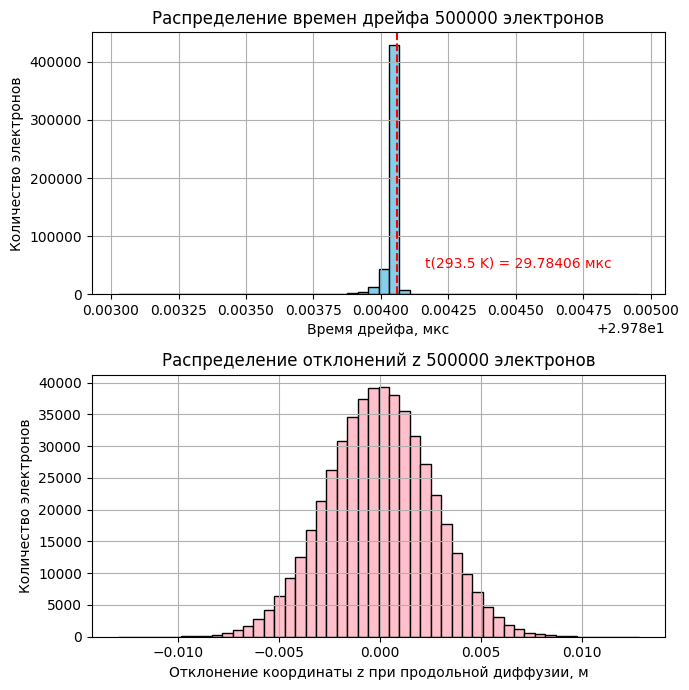

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(7, 7))


ax[0].hist(drift_times/1e-6, bins=50, color='skyblue', edgecolor='black')
ax[0].axvline(x=t_stab/1e-6, color='red', linestyle='--', linewidth=1.5)
ax[0].text((t_stab+max(drift_times))/2e-6, N*0.08, f't(293.5 K) = {round(t_stab/1e-6,5)} мкс', ha='center', va='bottom', fontsize=10, color='red')
ax[0].set_xlabel('Время дрейфа, мкс')
ax[0].set_ylabel('Количество электронов')
ax[0].set_title(f'Распределение времен дрейфа {N} электронов')
ax[0].grid(True)

# ax[1].hist(delta_z, bins=50, color='gold', edgecolor='black')
# # ax[1].axvline(x=L, color='red', linestyle='--', linewidth=1.5)
# # ax[1].text((L+max(delta_z))/2, N*0.08, f'L = {L} м', ha='center', va='bottom', fontsize=10, color='red')
# ax[1].set_xlabel('Длина пути дрейфа, м')
# ax[1].set_ylabel('Количество электронов')
# ax[1].set_title(f'Распределение длин пути дрейфа {N} электронов')
# ax[1].grid(True)

ax[1].hist(delta_xyz[2], bins=50, color='pink', edgecolor='black')
# ax[1].axvline(x=L, color='red', linestyle='--', linewidth=1.5)
# ax[1].text((L+max(delta_z))/2, N*0.08, f'L = {L} м', ha='center', va='bottom', fontsize=10, color='red')
ax[1].set_xlabel('Отклонение координаты z при продольной диффузии, м')
ax[1].set_ylabel('Количество электронов')
ax[1].set_title(f'Распределение отклонений z {N} электронов')
ax[1].grid(True)

plt.tight_layout()
plt.show()

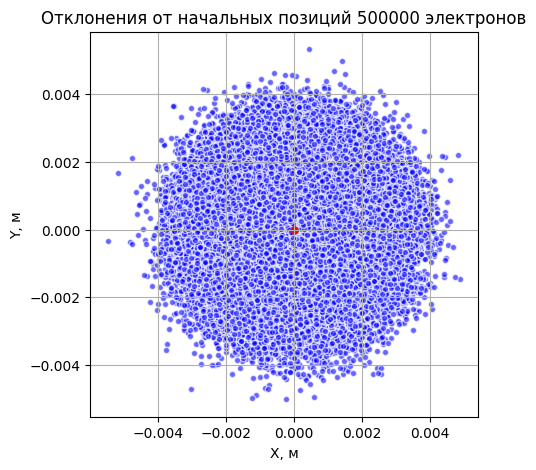

In [ ]:
plt.figure(figsize=(5, 5))
plt.scatter(delta_xyz[0], delta_xyz[1], s=20, c='blue', alpha=0.6, edgecolors='w')
plt.scatter(0, 0, s=27, c='red')
plt.title(f"Отклонения от начальных позиций {N} электронов")
# plt.xlim(-R_outer*1.1, R_outer*1.1)
# plt.ylim(-R_outer*1.1, R_outer*1.1)
plt.xlabel('X, м')
plt.ylabel('Y, м')
plt.grid(True)
plt.show()

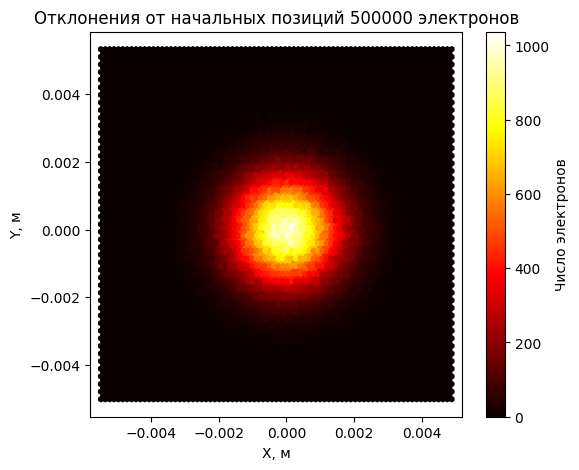

In [ ]:
plt.figure(figsize=(6, 5))
hb = plt.hexbin(delta_xyz[0], delta_xyz[1],
                gridsize=80,
                mincnt=0,
                cmap='hot')

plt.colorbar(hb, label='Число электронов')
plt.xlabel('X, м')
plt.ylabel('Y, м')
plt.title(f"Отклонения от начальных позиций {N} электронов")
plt.axis('equal')
plt.show()
